# Testing the tensor network simulator with 2-local Hayden-Preskill circuits


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

**Abstract:** We study a class of random quantum circuits known as Hayden-Preskill circuits using the tensor network simulator backend in Amazon Braket. The goal is to understand the degree to which the tensor network simulator is capable of detecting a hidden local structure in a quantum circuit, while simultaneously building experience with the Amazon Braket service and SDK. We find that the TN1 tensor network simulator can efficiently simulate local random quantum circuits, even when the local structure is obfuscated by permuting the qubit indices. Conversely, when running genuinely non-local versions of the quantum circuits, the simulator's performance is significantly degraded.

This notebook is aimed at users who are familiar with Amazon Braket and have a working knowledge of quantum computing and quantum circuits.

In [2]:
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

#### Setup the tensor network simulator:
In this notebook we will use the TN1 simulator on Amazon Braket [[1]](#References):

In [3]:
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/tn1")

## Local Hayden-Preskill Circuits

Hayden-Preskill circuits are a class of unstructured, random quantum circuits.  To produce a Hayden-Preskill circuit, one chooses a gate at random from some universal gate set at each time step and applies this gate to random target qubits.  For example, one can choose to either apply a random single qubit rotation to a random qubit, or a CZ gate to a random pair of qubits at each time step.  As a concrete example, consider the following pseudocode:
```
Choose either {single qubit, two qubit} gate w/ prob. {1/2, 1/2}
 
If single qubit:
    Choose either {Rx, Ry, Rz, H} randomly w/ prob. {1/4, 1/4, 1/4, 1/4}    
    Apply the chosen gate to a randomly chosen qubit
    If the gate is Rx, Ry, or Rz, rotate by a randomly chosen angle
 
If two qubit gate:
    Choose (qubit 1, qubit 2) to be two randomly chosen qubits out of the set of N qubits
    Apply CZ(qubit 1, qubit 2) # This means the couplings are long range, all-to-all
```

Using the strategy above, one can quickly generate random circuits with all-to-all, long-range couplings.  These circuits generate unitaries that rapidly converge to Haar random unitaries, and they are difficult to simulate.  

A much simpler class of random circuits, which we call **local Hayden-Preskill circuits**, can be generated using the same strategy as above, but in which the two qubit CZ gates are applied to nearest neighbour qubits instead of random pairs:
```
Choose a random qubit j from [0, N-2]
Apply CZ(qubit j, qubit j+1)
```

#### In this notebook, we will focus on both local and non-local Hayden-Preskill circuits, defined using the helper functions below.

In [4]:
def CZtuple_generator(qubits):
    """Yields a CZ between a random qubit and its next nearest neighbor.
    For simplicity, we choose a random qubit from the first N-1 qubits for
    the control and we set the target to be qubit i+1, where i is the control."""
    a = np.random.choice(range(len(qubits)-1), 1, replace=True)[0]
    yield Circuit().cz(qubits[a],qubits[a+1])

def local_Hayden_Preskill_generator(qubits,numgates):
    """Yields the circuit elements for a scrambling unitary.
    Generates a circuit with numgates gates by laying down a
    random gate at each time step.  Gates are chosen from single
    qubit unitary rotations by a random angle, Hadamard, or a 
    controlled-Z between a qubit and its nearest neighbor (i.e.,
    incremented by 1)."""
    for i in range(numgates):
        yield np.random.choice([
            Circuit().rx(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().ry(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().rz(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().h(np.random.choice(qubits,1,replace=True)),
            CZtuple_generator(qubits), # For all-to-all: Circuit().cz(*np.random.choice(qubits,2,replace=False)),
            ],1,replace=True,p=[1/8,1/8,1/8,1/8,1/2])
        
def non_local_Hayden_Preskill_generator(qubits,numgates):
    """Yields the circuit elements for a scrambling unitary.
    Generates a circuit with numgates gates by laying down a
    random gate at each time step.  Gates are chosen from single
    qubit unitary rotations by a random angle, Hadamard, or a 
    controlled-Z between a qubit and its nearest neighbor (i.e.,
    incremented by 1)."""
    for i in range(numgates):
        yield np.random.choice([
            Circuit().rx(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().ry(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().rz(np.random.choice(qubits,1,replace=True),np.random.ranf()),
            Circuit().h(np.random.choice(qubits,1,replace=True)),
            Circuit().cz(*np.random.choice(qubits,2,replace=False)),
            ],1,replace=True,p=[1/8,1/8,1/8,1/8,1/2])

We use the helper functions above to generate local Hayden-Preskill (random) quantum circuits. For example:

In [5]:
# Generate an example of a local Hayden Preskill circuit
test_circuit = Circuit()
test_circuit.add(local_Hayden_Preskill_generator(range(5),20))
print(test_circuit)

T  : |   0    |    1    |    2    |3|    4     |5|6|7|8|9|
                                                          
q0 : -H------------------C---------C-Rx(0.389)--C-C-C-----
                         |         |            | | |     
q1 : -C--------Rx(0.37)--Z---------Z-Rx(0.464)--Z-Z-Z-----
      |                                                   
q2 : -Z--------Ry(0.508)-Rz(0.562)-C------------------C---
                                   |                  |   
q3 : -Rx(0.26)---------------------Z-Ry(0.0278)-C-C-C-Z-C-
                                                | | |   | 
q4 : -------------------------------------------Z-Z-Z---Z-

T  : |   0    |    1    |    2    |3|    4     |5|6|7|8|9|


In [6]:
# Generate an example of a non-local Hayden Preskill circuit
test_circuit = Circuit()
test_circuit.add(non_local_Hayden_Preskill_generator(range(5),20))
print(test_circuit)

T  : | 0 |     1     |    2     |3|    4    |    5    |    6    |7|8|9|10 |   11    |
                                                                                     
q0 : -Z---C-----------Rz(0.0273)---C---------Ry(0.634)-------------------------------
      |   |                        |                                                 
q1 : -|---|-----------C----------C-Z-----------------------------Z-------C-----------
      |   |           |          |                               |       |           
q2 : -|---|-----------|----------Z-Ry(0.435)-Rx(0.527)-Rz(0.172)-C-C---Z-|-Ry(0.643)-
      |   |           |                                            |   | |           
q3 : -|-H-|-Rz(0.375)-|--------------------------------------------Z-Z-|-Z-----------
      |   |           |                                              | |             
q4 : -C---Z-----------Z----------H-Ry(0.921)-------------------------C-C-------------

T  : | 0 |     1     |    2     |3|    4    |    5   

## Simulating _local_ random circuits using the TN1 tensor network simulator

### Testing and timing

Let's start with a reasonably sized circuit

In [7]:
num_qubits = 20                     # Number of qubits
num_layers = 10                     # Number of layers.  A layer consists of num_qubits gates.
numgates = num_qubits * num_layers  # Total number of gates.
print(f"{num_qubits} qubits, {num_layers} layers = {numgates} total gates")
circ = Circuit()
circ.add(local_Hayden_Preskill_generator(range(num_qubits), numgates));  # Create the circuit with numgates gates.

20 qubits, 10 layers = 200 total gates


Time this circuit using TN1.  It should take about a minute or so.

Running: 20 qubits, 10 layers = 200 total gates
ID of task: arn:aws:braket:us-west-2:586882978732:quantum-task/4e870cf6-c25b-4457-b03d-b40e6438e96f
Status of task: CREATED
Status: RUNNING
Status: RUNNING
Status: COMPLETED
CPU times: user 895 ms, sys: 7.99 ms, total: 903 ms
Wall time: 1min 1s


<BarContainer object of 921 artists>

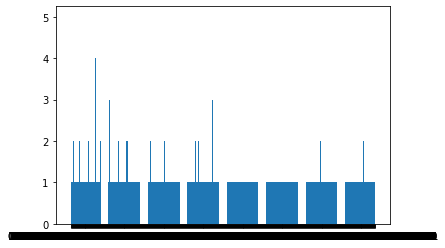

In [8]:
%%time
# define task
print(f"Running: {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
task = device.run(circ, shots=1000, poll_timeout_seconds = 1000)

# get id and status of submitted task
task_id = task.id
status = task.state()
print('ID of task:', task_id)
print('Status of task:', status)

# wait for job to complete
terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
while status not in terminal_states:
    time.sleep(20) # Update this for shorter circuits.
    status = task.state()
    print('Status:', status)

# get results of task
result = task.result()

# get measurement shots
counts = result.measurement_counts
plt.bar(counts.keys(), counts.values());

### The importance of locality in circuits

The goal of this section is to understand the importance of a local structure in quantum circuits being simulated in the tensor network simulator.  We will first generate and benchmark a local Hayden-Preskill circuit, and then we will re-run the exact same circuit with the qubits randomly permuted. By permuting the qubits, we produce a circuit that appears to be have non-local, long-range coupling, but for which we know that there exists an underlying local structure.

An example of a circuit and its permuted version is shown below.  A local Hayden-Preskill circuit is generated, and then a version of the same circuit is created in which the qubits are randomly permuted, according to the permutation [0,1,2,3,4,5]$\mapsto$[5,2,4,1,0,3].

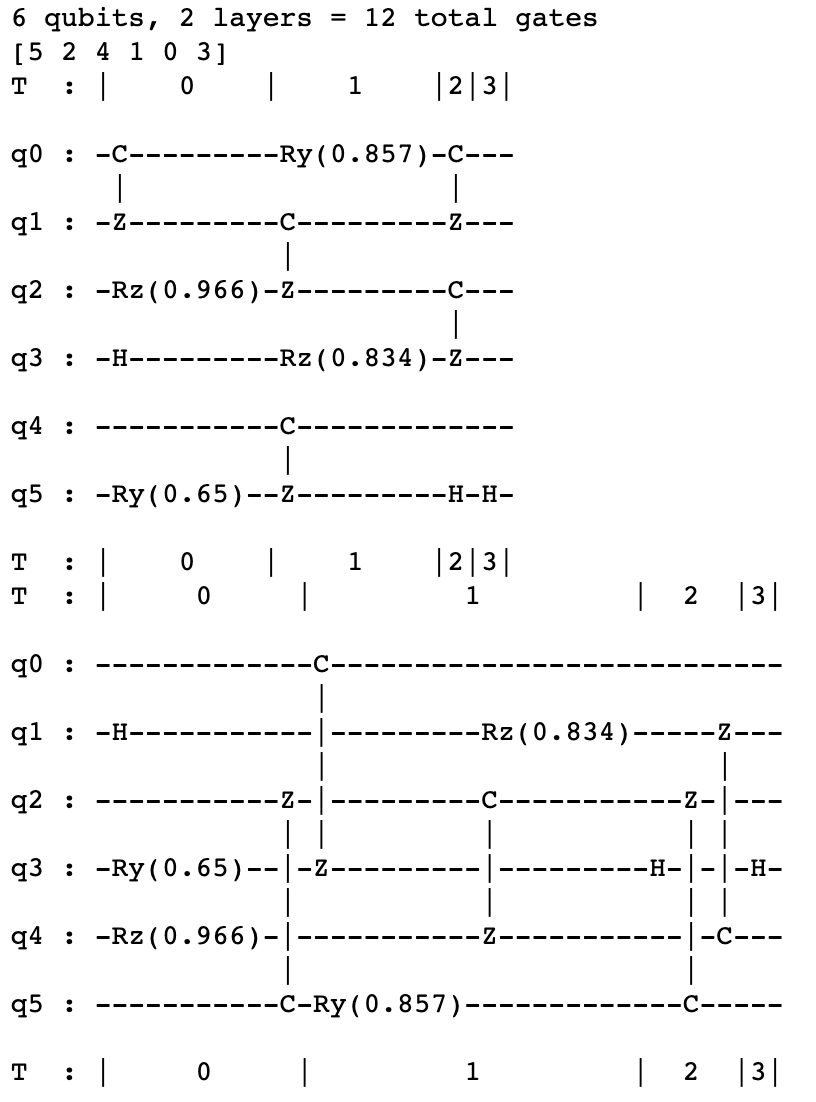

In [9]:
from IPython.display import Image
Image(filename='permuted_circuit.png', width=400)

With these two circuits (that seem to have vastly different locality, but which are "secretly" the same), we can explore the tensor network simulator's ability to discern structure in a given circuit.

First generate a modest sized local Hayden-Preskill circuit.  Then make a copy of that circuit by permuting the qubit indices randomly.  We'll compare the runtime to sample from the outputs of these two circuits.

In [10]:
num_qubits = 50                     # Number of qubits
num_layers = 10                     # Number of layers.  A layer consists of num_qubits gates.
numgates = num_qubits * num_layers  # Total number of gates.
qubits=range(num_qubits)            # Generate the (1D) qubits
print(f"{num_qubits} qubits, {num_layers} layers = {numgates} total gates")

# Generate the circuit with numgates gates acting on qubits.
circ = Circuit()
circ.add(local_Hayden_Preskill_generator(qubits,numgates));

# Choose a random permutation of the qubits
permuted_qubits=np.random.permutation(qubits)

# Copy the circuit circ acting on the permuted qubits
perm = Circuit().add_circuit(circ, target_mapping=dict(zip(qubits, permuted_qubits)))

##Uncomment for testing:
# print(permuted_qubits)
# print(circ)
# print(perm)

50 qubits, 10 layers = 500 total gates


Time both circuits using the tensor network simulator for a **single shot**.

In [11]:
%%time
# define task
task = device.run(circ, shots=1, poll_timeout_seconds = 1000)

# get results of task
result = task.result()

# get measurement shots
print(f"Running the local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
counts = result.measurement_counts
print(f"The sample was: {next(iter(counts))}.")

Running the local circuit with 50 qubits, 10 layers = 500 total gates
The sample was: 01011001101000001000011100110000001011010001100100.
CPU times: user 100 ms, sys: 2.76 ms, total: 103 ms
Wall time: 10.6 s


In [12]:
%%time
# define task
task = device.run(perm, shots=1, poll_timeout_seconds = 1000)

# get results of task
result = task.result()

# get measurement shots
print(f"Running the non-local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
counts = result.measurement_counts
print(f"The sample was: {next(iter(counts))}.")

Running the non-local circuit with 50 qubits, 10 layers = 500 total gates
The sample was: 11000010100100011011001010000100000110001000100001.
CPU times: user 161 ms, sys: 3.42 ms, total: 164 ms
Wall time: 28.2 s


If you repeat these experiments, you'll find that the two runtimes are (typically) very similar! Even though the permuted circuit seems to be highly non-local at first glance, the simulator discovers the underlying local structure, and the total runtime is comparable to the manifestly local circuit. This similarity is due to the rehearsal phase of the tensor network simulation [[1]](#References). A sophisticated algorithm works behind the scenes to find an efficient path for contracting the tensor network. Thus, when the tensor network has an underlying structure, the tensor network simulator can often tease it out.

## Simulating _non-local_ random circuits using the TN1 tensor network simulator

Let us now compare the efficiency of simulating local and genuinely non-local random quantum circuits. When using the non-local Hayden Preskill circuits above, the circuits we generate have no underlying structure, making them especially difficult for the tensor network simulator.

We will generate one local random circuit and one non-local quantum circuit of the same size, and we will compare their runtimes. In this section, the we will not be comparing identical quantum circuits as we were above, so our results can be understood by repeating these experiments several times and noting that our claims are true on average.

In [13]:
num_qubits = 50                     # Number of qubits
num_layers = 8                      # Number of layers.  A layer consists of num_qubits gates.
numgates = num_qubits * num_layers  # Total number of gates.
qubits=range(num_qubits)            # Generate the (1D) qubits
print(f"{num_qubits} qubits, {num_layers} layers = {numgates} total gates")

# Generate the local circuit with numgates gates acting on qubits.
localcirc = Circuit()
localcirc.add(local_Hayden_Preskill_generator(qubits,numgates));

# Generate the non-local circuit with numgates gates acting on qubits.
nonlocalcirc = Circuit()
nonlocalcirc.add(non_local_Hayden_Preskill_generator(qubits,numgates));

##Uncomment for testing:
# print(permuted_qubits)
# print(circ)
# print(perm)

50 qubits, 8 layers = 400 total gates


Run the local circuit:

In [14]:
%%time
# define task
task = device.run(localcirc, shots=1, poll_timeout_seconds = 1000)

# get results of task
result = task.result()

# get measurement shots
print(f"Running the local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
counts = result.measurement_counts
print(f"The sample was: {next(iter(counts))}.")

Running the local circuit with 50 qubits, 8 layers = 400 total gates
The sample was: 01000011010100011111010010101101000000000000111010.
CPU times: user 99.7 ms, sys: 436 µs, total: 100 ms
Wall time: 10.5 s


Run the non-local circuit:

In [15]:
%%time
# define task
task = device.run(nonlocalcirc, shots=1, poll_timeout_seconds = 1000)

# get results of task
result = task.result()

# get measurement shots
print(f"Running the non-local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
counts = result.measurement_counts
print(f"The sample was: {next(iter(counts))}.")

Running the non-local circuit with 50 qubits, 8 layers = 400 total gates
The sample was: 01000110001010011000000001001010001000001000111100.
CPU times: user 118 ms, sys: 13 ms, total: 131 ms
Wall time: 20.3 s


When running this notebook several times, we find that the non-local circuit generally takes 2-3 times longer to run than the local circuit. However, on occasion the non-local circuit fails to run, for a reason we will explore below.

## Non-local circuits quickly become too difficult for tensor network methods

In this section, we will compare larger circuits with and without locality. We will see that the local circuits execute very efficiently on the tensor network simulator, whereas the non-local circuits actually fail in the rehearsal phase.

We start by generating these larger circuits:

In [16]:
num_qubits = 50                     # Number of qubits
num_layers = 20                     # Number of layers.  A layer consists of num_qubits gates.
numgates = num_qubits * num_layers  # Total number of gates.
qubits=range(num_qubits)            # Generate the (1D) qubits
print(f"{num_qubits} qubits, {num_layers} layers = {numgates} total gates")

# Generate the circuit with numgates gates acting on qubits.
localcirc = Circuit()
localcirc.add(local_Hayden_Preskill_generator(qubits,numgates));

# Generate the circuit with numgates gates acting on qubits.
nonlocalcirc = Circuit()
nonlocalcirc.add(non_local_Hayden_Preskill_generator(qubits,numgates));

##Uncomment for testing:
# print(permuted_qubits)
# print(circ)
# print(perm)

50 qubits, 20 layers = 1000 total gates


The local Hayden Preskill circuit executes in a reasonable amount of time, generally about a minute or so:

In [17]:
%%time
# define task
task = device.run(localcirc, shots=1, poll_timeout_seconds = 1000)

# get results of task
result = task.result()

# get measurement shots
print(f"Running the local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
counts = result.measurement_counts
print(f"The sample was: {next(iter(counts))}.")

Running the local circuit with 50 qubits, 20 layers = 1000 total gates
The sample was: 01010111001000001010000000100011110000110001110101.
CPU times: user 201 ms, sys: 7.95 ms, total: 209 ms
Wall time: 32.7 s


Conversely, the non-local Hayden Preskill circuit actually fails to execute:

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell can take several minutes to run on TN1. It is only present to illustrate a task that will result in a FAILED state. To run this cell, uncomment it.
</div>

In [18]:
#%%time
## define task
#task = device.run(nonlocalcirc, shots=1, poll_timeout_seconds = 1000)

## get results of task
#result = task.result()

## get measurement shots
#print(f"Running the non-local circuit with {num_qubits} qubits, {num_layers} layers = {numgates} total gates")
## counts = result.measurement_counts
## print(f"The sample was: {next(iter(counts))}.")

Task is in terminal state FAILED and no result is available


Running the non-local circuit with 50 qubits, 20 layers = 1000 total gates
CPU times: user 411 ms, sys: 19.4 ms, total: 431 ms
Wall time: 1min 56s


To see why this circuit `FAILED` to run, we can check the `failureReason` in the task's `_metadata`:

In [19]:
#print(task._metadata['failureReason'])

Predicted runtime based on best contraction path found exceeds TN1 limit. Single-shot FLOPS estimate = 2^105


Evidently, without any structure to exploit, this tensor network would take too long to simulate, and the simulator returns with a `FAILED` state.

## Conclusions

We saw that structured quantum circuits can be simulated much more efficiently than unstructured random quantum circuits. That said, structure in a quantum circuit may not be immediately evident, as the tensor network simulator was able to discover the hidden structure in our permuted quantum circuits, leading to efficiency on-par with their unpermuted, local counterparts. Note, however, that discovering this underlying structure is analogous to the graph isomorphism problem, and finding an efficient contraction path for a tensor network is a hard problem.

## Appendix

In [20]:
# Check SDK version
# alternative: braket.__version__
!pip show amazon-braket-sdk | grep Version

Version: 1.5.0


## References
[1] [Amazon Braket Documentation: Tensor Network Simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-tn1)

In [23]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print('This estimate does not inclued the task which fails after rehersal, for which charges may apply. See https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html for more details.')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/tn1': {'shots': 1006, 'tasks': {'COMPLETED': 6, 'FAILED': 1}, 'execution_duration': datetime.timedelta(seconds=124, microseconds=18000), 'billed_execution_duration': datetime.timedelta(seconds=124, microseconds=18000)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
This estimate does not inclued the task which fails after rehersal, for which charges may apply. See https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html for more details.
Estimated cost to run this example: 0.568 USD
